<ipython-input-1-86c93ccac5e1>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cleaned['CustomerDOB'] = pd.to_datetime(df_cleaned['CustomerDOB'], errors='coerce', dayfirst=True)


Top 5 Locations with Highest Transactions:
 CustLocation
MUMBAI       86290
BANGALORE    70701
NEW DELHI    66172
GURGAON      62746
DELHI        60490
Name: count, dtype: int64


<ipython-input-1-86c93ccac5e1>:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cleaned['TransactionDate'] = pd.to_datetime(df_cleaned['TransactionDate'], errors='coerce')


                     TransactionDate        Recency      Frequency  \
count                         761365  761365.000000  761365.000000   
mean   2016-07-31 16:50:05.906496256     130.298543       1.155458   
min              2016-01-08 00:00:00       0.000000       1.000000   
25%              2016-07-08 00:00:00      86.000000       1.000000   
50%              2016-08-21 00:00:00     110.000000       1.000000   
75%              2016-09-14 00:00:00     154.000000       1.000000   
max              2016-12-09 00:00:00     336.000000       6.000000   
std                              NaN      80.748131       0.409379   

           Monetary  
count  7.613650e+05  
mean   1.469326e+03  
min    1.000000e-02  
25%    1.750000e+02  
50%    4.880000e+02  
75%    1.245000e+03  
max    1.560035e+06  
std    5.835058e+03  


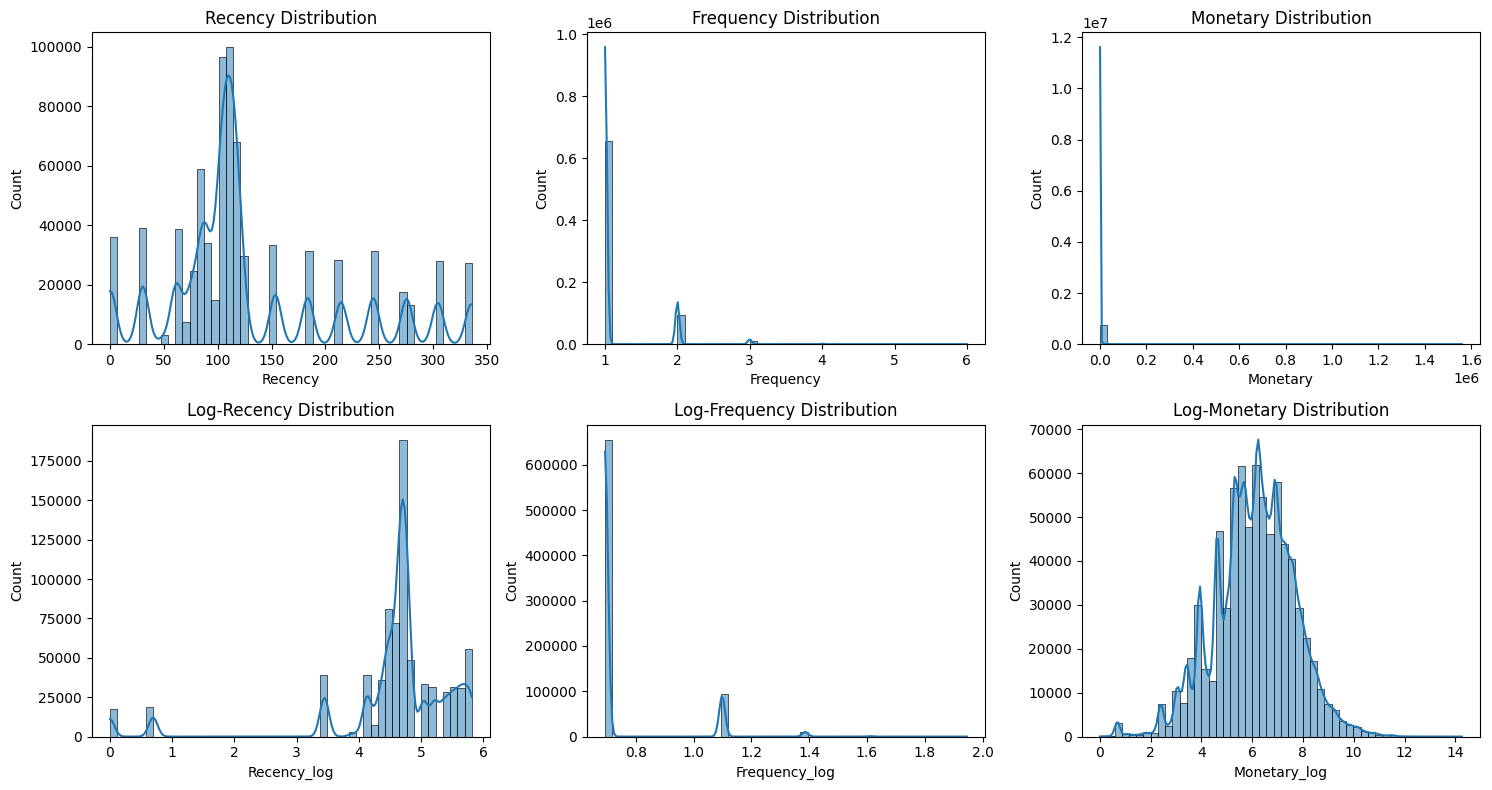

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "bank_transactions.csv"  # Update with correct file path
df = pd.read_csv(file_path)

# Step 1: Remove null values in essential columns
df_cleaned = df.dropna(subset=['CustomerDOB', 'CustLocation', 'CustAccountBalance', 'TransactionAmount (INR)'])

# Step 2: Remove invalid transaction amounts (≤ 0)
df_cleaned = df_cleaned[df_cleaned['TransactionAmount (INR)'] > 0]

# Step 3: Convert 'CustomerDOB' to Age and remove invalid ages
df_cleaned['CustomerDOB'] = pd.to_datetime(df_cleaned['CustomerDOB'], errors='coerce', dayfirst=True)
df_cleaned['Age'] = (pd.to_datetime('today') - df_cleaned['CustomerDOB']).dt.days // 365
df_cleaned = df_cleaned[(df_cleaned['Age'] >= 18) & (df_cleaned['Age'] <= 100)]

# Step 4: Identify the top 5 locations with the highest transactions
top_locations = df_cleaned['CustLocation'].value_counts().head(5)
print("Top 5 Locations with Highest Transactions:\n", top_locations)

# Step 5: Define reference date & compute Recency, Frequency, Monetary values
df_cleaned['TransactionDate'] = pd.to_datetime(df_cleaned['TransactionDate'], errors='coerce')
reference_date = df_cleaned['TransactionDate'].max()

recency_df = df_cleaned.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency_df['Recency'] = (reference_date - recency_df['TransactionDate']).dt.days

frequency_df = df_cleaned.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency_df.rename(columns={'TransactionID': 'Frequency'}, inplace=True)

monetary_df = df_cleaned.groupby('CustomerID')['TransactionAmount (INR)'].sum().reset_index()
monetary_df.rename(columns={'TransactionAmount (INR)': 'Monetary'}, inplace=True)

rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

# Step 6: Check distribution of RFM values
print(rfm_df.describe())

# Step 7: Address skewness with log transformation
rfm_df['Recency_log'] = np.log1p(rfm_df['Recency'])
rfm_df['Frequency_log'] = np.log1p(rfm_df['Frequency'])
rfm_df['Monetary_log'] = np.log1p(rfm_df['Monetary'])

# Visualizing distributions before and after log transformation
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

sns.histplot(rfm_df['Recency'], bins=50, kde=True, ax=axes[0, 0]).set_title('Recency Distribution')
sns.histplot(rfm_df['Frequency'], bins=50, kde=True, ax=axes[0, 1]).set_title('Frequency Distribution')
sns.histplot(rfm_df['Monetary'], bins=50, kde=True, ax=axes[0, 2]).set_title('Monetary Distribution')

sns.histplot(rfm_df['Recency_log'], bins=50, kde=True, ax=axes[1, 0]).set_title('Log-Recency Distribution')
sns.histplot(rfm_df['Frequency_log'], bins=50, kde=True, ax=axes[1, 1]).set_title('Log-Frequency Distribution')
sns.histplot(rfm_df['Monetary_log'], bins=50, kde=True, ax=axes[1, 2]).set_title('Log-Monetary Distribution')

plt.tight_layout()
plt.show()


In [5]:
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm_df['F_Score'] = pd.cut(rfm_df['Frequency'].rank(method="average"), bins=5, labels=[1, 2, 3, 4, 5])
rfm_df['M_Score'] = pd.cut(rfm_df['Monetary'].rank(method="average"), bins=5, labels=[1, 2, 3, 4, 5])


In [7]:
import pandas as pd

# Assigning RFM scores from 1 to 5 using quantiles
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm_df['F_Score'] = pd.cut(rfm_df['Frequency'].rank(method="average"), bins=5, labels=[1, 2, 3, 4, 5])
rfm_df['M_Score'] = pd.cut(rfm_df['Monetary'].rank(method="average"), bins=5, labels=[1, 2, 3, 4, 5])
# Combine scores into a single RFM Score
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

# Define customer segments based on RFM score
def segment_customers(rfm):
    if rfm in ['555', '554', '545', '544']:
        return 'Best Customers'
    elif rfm in ['543', '535', '534', '533']:
        return 'Loyal Customers'
    elif rfm in ['155', '144', '133', '122']:
        return 'Churned Customers'
    elif rfm in ['511', '422', '411', '311']:
        return 'At Risk Customers'
    elif rfm in ['344', '355', '333', '322']:
        return 'Potential Loyalists'
    else:
        return 'Other'

rfm_df['Segment'] = rfm_df['RFM_Score'].apply(segment_customers)

# Display customer segment distribution
segment_counts = rfm_df['Segment'].value_counts()
print("Customer Segment Distribution:\n", segment_counts)

# Save the final segmented dataset
rfm_df.to_csv("rfm_segmented_customers.csv", index=False)
print("Segmented RFM data saved as 'rfm_segmented_customers.csv'")


Customer Segment Distribution:
 Segment
Other                  633931
At Risk Customers       90554
Best Customers          26483
Potential Loyalists      8582
Churned Customers        1815
Name: count, dtype: int64
Segmented RFM data saved as 'rfm_segmented_customers.csv'


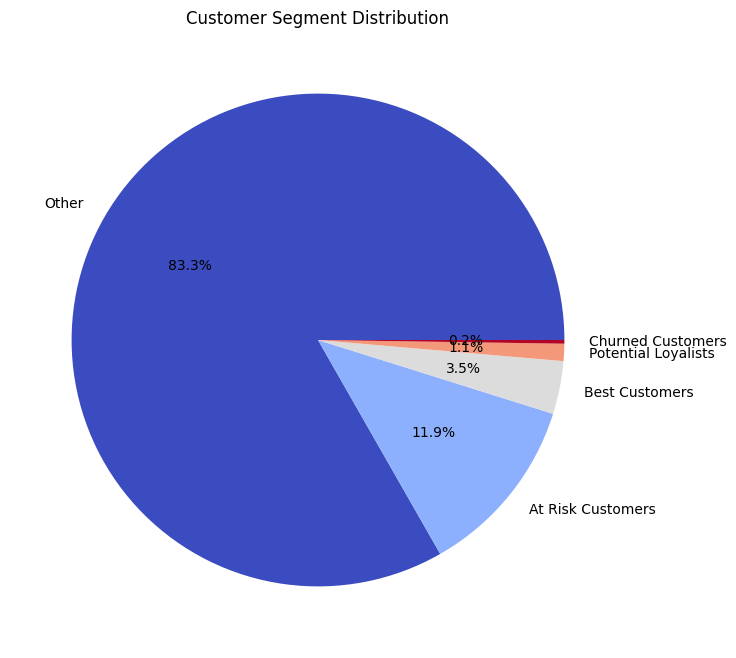

In [8]:
import matplotlib.pyplot as plt

# Plot customer segment distribution
segment_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), cmap='coolwarm')
plt.title('Customer Segment Distribution')
plt.ylabel('')
plt.show()


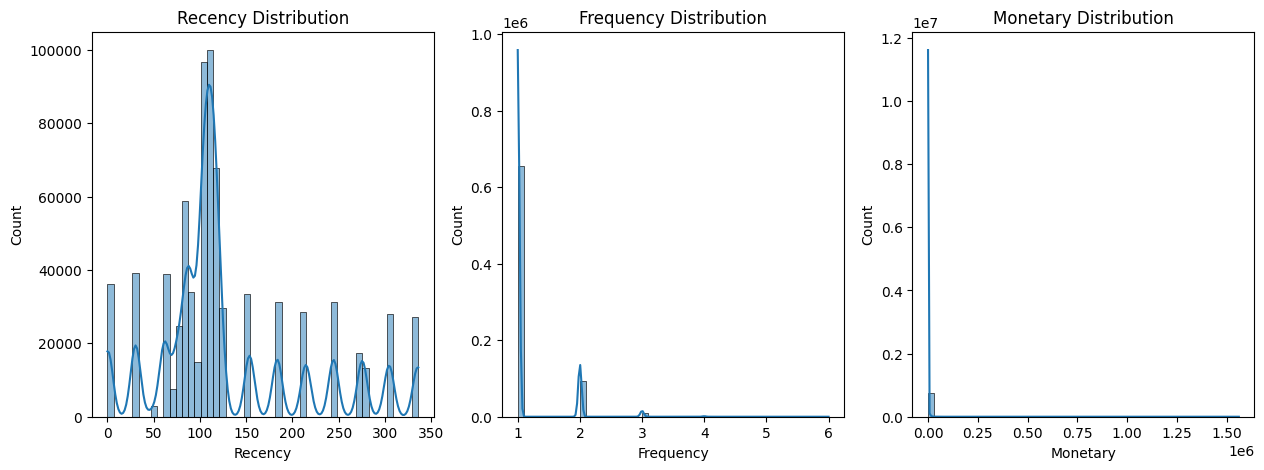

In [9]:
import seaborn as sns

# Visualizing RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(rfm_df['Recency'], bins=50, kde=True, ax=axes[0]).set_title('Recency Distribution')
sns.histplot(rfm_df['Frequency'], bins=50, kde=True, ax=axes[1]).set_title('Frequency Distribution')
sns.histplot(rfm_df['Monetary'], bins=50, kde=True, ax=axes[2]).set_title('Monetary Distribution')
plt.show()


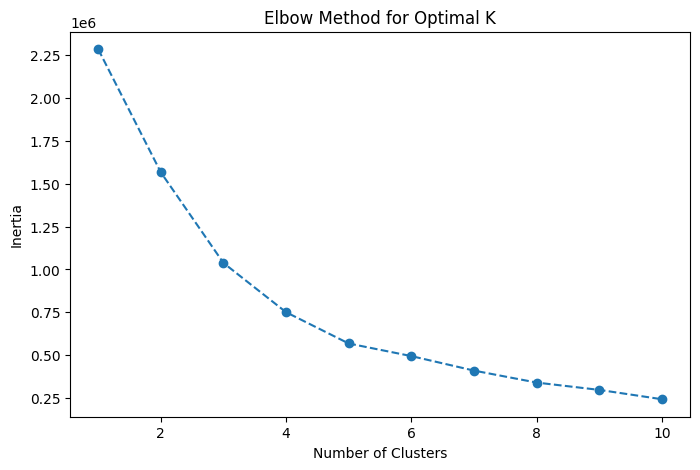

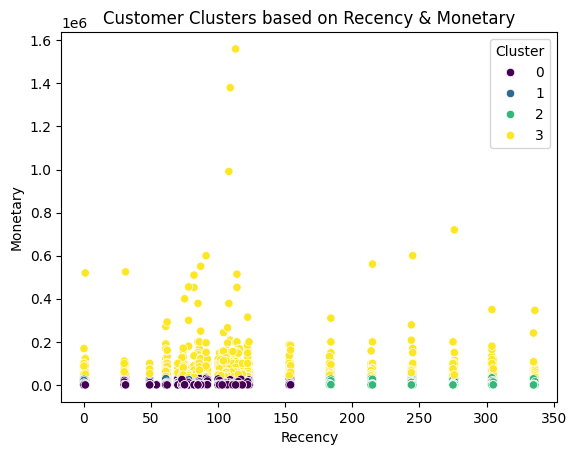

Clustered RFM data saved as 'rfm_clustered_customers.csv'


In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Standardize RFM values for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Find optimal number of clusters using Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Apply K-Means clustering with optimal K (let's assume K=4 based on the elbow curve)
optimal_k = 4  # Adjust based on the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Clusters based on Recency & Monetary')
plt.show()

# Save clustered data
rfm_df.to_csv("rfm_clustered_customers.csv", index=False)
print("Clustered RFM data saved as 'rfm_clustered_customers.csv'")


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create Churn Column (1 if Recency > 90 days, else 0)
rfm_df['Churn'] = (rfm_df['Recency'] > 90).astype(int)

# Define Features and Target
X = rfm_df[['Recency', 'Frequency', 'Monetary']]
y = rfm_df['Churn']

# Split Data into Training & Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on Test Data
y_pred = model.predict(X_test)

# Evaluate Model Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62478
           1       1.00      1.00      1.00    165932

    accuracy                           1.00    228410
   macro avg       1.00      1.00      1.00    228410
weighted avg       1.00      1.00      1.00    228410

Confusion Matrix:
 [[ 62478      0]
 [     0 165932]]


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


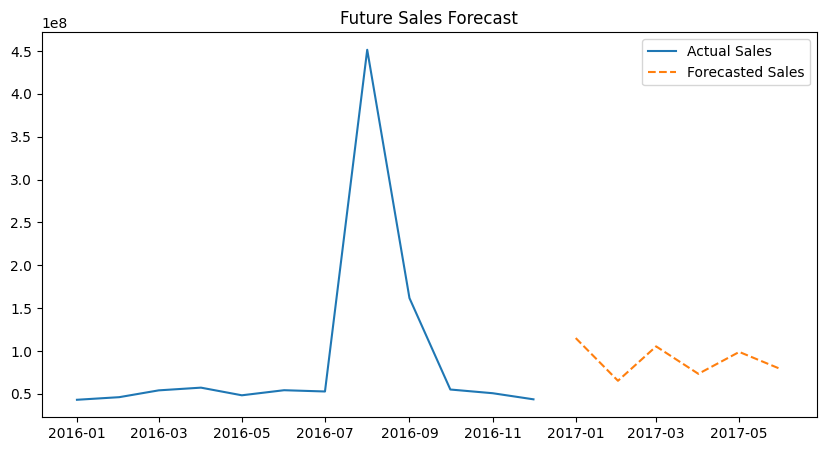

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Aggregate Monthly Sales Data
df_cleaned['TransactionDate'] = pd.to_datetime(df_cleaned['TransactionDate'])
monthly_sales = df_cleaned.groupby(df_cleaned['TransactionDate'].dt.to_period('M'))['TransactionAmount (INR)'].sum()
monthly_sales.index = monthly_sales.index.to_timestamp()

# Train ARIMA Model
model = ARIMA(monthly_sales, order=(2,1,2))  # You can adjust these parameters
model_fit = model.fit()

# Forecast Next 6 Months
forecast = model_fit.forecast(steps=6)

# Plot Results
plt.figure(figsize=(10,5))
plt.plot(monthly_sales, label='Actual Sales')
plt.plot(forecast, label='Forecasted Sales', linestyle='dashed')
plt.legend()
plt.title('Future Sales Forecast')
plt.show()
